In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix,roc_curve, auc)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.utils import resample
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.metrics import precision_recall_curve
import shap

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ====================== 中文显示配置 ======================
plt.rcParams['font.sans-serif'] = ['Times New Roman']  # Windows系统中文显示
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

In [3]:
df=pd.read_csv("D:/shuju/yiyu/2018nian.csv")
data=df[['gender','srh','adlab_c','arthre','digeste','retire','satlife','sleep','disability','shangwang'
        ,'hope','fall_down','eyesight_close','hear','edu','pension','tengtong','yiyu']]
df1=pd.read_csv("D:/shuju/yiyu/2013nian.csv")
data_val=df1[['gender','srh','adlab_c','arthre','digeste','retire','satlife','sleep','disability','shangwang'
        ,'hope','fall_down','eyesight_close','hear','edu','pension','tengtong','yiyu']]

In [4]:
if data.isna().any().any():
    print("数据data中存在缺失值")
else:
    print("数据data完整，无缺失值")

数据data完整，无缺失值


In [5]:
x= data.drop(columns=['yiyu'])
y= data['yiyu']

In [6]:
from sklearn.preprocessing import OneHotEncoder# 定义分类列
categorical_cols = [
    'gender', 'srh', 'arthre', 'digeste', 'retire', 'satlife', 
    'disability', 'shangwang', 'hope', 'fall_down', 'eyesight_close', 
    'hear', 'edu', 'pension', 'tengtong'
]
# 初始化 OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)
# 对分类列进行独热编码
x_encoded = pd.DataFrame(
    encoder.fit_transform(x[categorical_cols]), 
    columns=encoder.get_feature_names_out(categorical_cols)
)
# 合并回原始数据
x = pd.concat([x.drop(columns=categorical_cols), x_encoded], axis=1)

val_cols =['sleep','adlab_c']
scaler=StandardScaler()
x[val_cols]=scaler.fit_transform(x[val_cols])

In [7]:
x=x.astype(np.float32)

In [8]:
x_val= data_val.drop(columns=['yiyu'])
y_val= data_val['yiyu']

In [9]:
# 定义分类列
valcategorical_cols = [
    'gender', 'srh', 'arthre', 'digeste', 'retire', 'satlife', 
    'disability', 'shangwang', 'hope', 'fall_down', 'eyesight_close', 
    'hear', 'edu', 'pension', 'tengtong']
# 初始化 OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)
# 对存在的分类列进行独热编码
x_val_encoded = pd.DataFrame(
    encoder.fit_transform(x_val[valcategorical_cols]), 
    columns=encoder.get_feature_names_out(valcategorical_cols)
)
x_val = pd.concat([x_val.drop(columns=valcategorical_cols), x_val_encoded], axis=1)

In [10]:
valval_cols =['sleep','adlab_c']
scaler=StandardScaler()
x_val[val_cols]=scaler.fit_transform(x_val[valval_cols])

In [11]:
x_val=x_val.astype(np.float32)

In [12]:
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.3, random_state=45)

训练集（无任何修改,模型为默认参数，对模型进行训练）
测试集（寻找模型最佳参数）
验证集（对模型效果进行评价）

In [13]:
from sklearn.model_selection import StratifiedKFold
# 定义skf
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [14]:
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

Logistic

In [15]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [16]:
# 构建处理流程（包含重采样）
logit_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),        # 标准化
    ('clf', LogisticRegression(
        max_iter=1000,  # 增加迭代次数确保收敛
        random_state=42,
        class_weight='balanced',  # 类别权重平衡 
    ))
])
# 第一阶段：10折交叉验证训练
print("正在进行10折交叉验证训练...")
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_metrics = []

for fold_idx, (train_idx, valid_idx) in enumerate(outer_cv.split(x_train, y_train)):
    # 使用 .iloc 基于位置索引行数据
    x_fold_train, y_fold_train = x_train.iloc[train_idx], y_train.iloc[train_idx]
    x_fold_valid, y_fold_valid = x_train.iloc[valid_idx], y_train.iloc[valid_idx]
    # 训练模型（使用完整流程）
    logit_pipeline.fit(x_fold_train, y_fold_train)
    
    # 预测与评估
    y_pred = logit_pipeline.predict(x_fold_valid)
    y_proba = logit_pipeline.predict_proba(x_fold_valid)[:, 1]
    
    tn, fp, fn, tp = confusion_matrix(y_fold_valid, y_pred).ravel()
    fold_metrics = {
        'Accuracy': accuracy_score(y_fold_valid, y_pred),
        'Precision': precision_score(y_fold_valid, y_pred),
        'Recall': recall_score(y_fold_valid, y_pred),
        'Specificity': tn / (tn + fp),
        'F1': f1_score(y_fold_valid, y_pred),
        'AUC': roc_auc_score(y_fold_valid, y_proba)
    }
    cv_metrics.append(fold_metrics)


# 第二阶段：网格搜索调参
param_grid = [
    {
        'clf__penalty': ['l2'],
        'clf__C': [0.1,1,10],
        'clf__solver': ['liblinear', 'saga'],  # 这些solver支持L1/L2  
    }
]
LOgrid_search = GridSearchCV(
    estimator=logit_pipeline,
    param_grid=param_grid,  # 使用分组的参数网格
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

LOgrid_search.fit(x_train, y_train)

print("\n 最佳参数组合:")
for param, value in LOgrid_search.best_params_.items():
    print(f"{param}: {value}")

# 第三阶段：最终模型评估
LOfinal_model = LOgrid_search.best_estimator_
LOtest_pred = LOfinal_model.predict(x_test)
LOtest_proba = LOfinal_model.predict_proba(x_test)[:, 1]

# 计算所有指标
tn, fp, fn, tp = confusion_matrix(y_test, LOtest_pred).ravel()
LOtest_metrics = {
    'Accuracy': accuracy_score(y_test, LOtest_pred),
    'Precision': precision_score(y_test, LOtest_pred),
    'Recall': recall_score(y_test, LOtest_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_test, LOtest_pred),
    'AUC': roc_auc_score(y_test, LOtest_proba)
}
print(LOtest_metrics)

正在进行10折交叉验证训练...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

 最佳参数组合:
clf__C: 10
clf__penalty: l2
clf__solver: liblinear
{'Accuracy': 0.7542168674698795, 'Precision': 0.5796610169491525, 'Recall': 0.6812749003984063, 'Specificity': 0.7858376511226253, 'F1': 0.6263736263736264, 'AUC': 0.8113659352228391}


In [17]:
LOfinal_model = LOgrid_search.best_estimator_
LOval_pred = LOfinal_model.predict(x_val)
LOval_proba = LOfinal_model.predict_proba(x_val)[:, 1]

# 测试集评估
tn, fp, fn, tp = confusion_matrix(y_val, LOval_pred).ravel()
LOval_metrics = {
    'Accuracy': accuracy_score(y_val, LOval_pred),
    'Precision': precision_score(y_val, LOval_pred),
    'Recall': recall_score(y_val, LOval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_val, LOval_pred),
    'AUC': roc_auc_score(y_val, LOval_proba)
}

LOfinal_model = LOgrid_search.best_estimator_
LOval_pred = LOfinal_model.predict(x_train)
LOval_proba = LOfinal_model.predict_proba(x_train)[:, 1]

# 测试集评估
tn, fp, fn, tp = confusion_matrix(y_train, LOval_pred).ravel()
LOtrain_metrics = {
    'Accuracy': accuracy_score(y_train, LOval_pred),
    'Precision': precision_score(y_train, LOval_pred),
    'Recall': recall_score(y_train, LOval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_train, LOval_pred),
    'AUC': roc_auc_score(y_train, LOval_proba)
}
print(LOval_metrics)
print(LOtrain_metrics)

{'Accuracy': 0.7553816046966731, 'Precision': 0.5677083333333334, 'Recall': 0.7218543046357616, 'Specificity': 0.7694444444444445, 'F1': 0.6355685131195336, 'AUC': 0.8166114790286976}
{'Accuracy': 0.7880041365046536, 'Precision': 0.6485411140583555, 'Recall': 0.7712933753943217, 'Specificity': 0.7961538461538461, 'F1': 0.7046109510086456, 'AUC': 0.8658480951225429}


支持向量机

In [18]:
# 构建处理流程（包含重采样）
svm_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),        # 标准化（SVM必需）
    ('clf', SVC(
        probability=True,  # 启用概率预测（AUC必需）
        class_weight='balanced', 
        random_state=42,
        cache_size=1000,    # 提升大样本训练速度
    ))
])

# 第一阶段：10折交叉验证训练
print(" 正在进行10折交叉验证训练...")
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_metrics = []

for fold_idx, (train_idx, valid_idx) in enumerate(outer_cv.split(x_train, y_train)):
    x_fold_train, y_fold_train = x_train.iloc[train_idx], y_train.iloc[train_idx]
    x_fold_valid, y_fold_valid = x_train.iloc[valid_idx], y_train.iloc[valid_idx]
    
    # 训练模型（使用完整流程）
    svm_pipeline.fit(x_fold_train, y_fold_train)
    
    # 预测与评估
    y_pred = svm_pipeline.predict(x_fold_valid)
    y_proba = svm_pipeline.predict_proba(x_fold_valid)[:, 1]
    
    tn, fp, fn, tp = confusion_matrix(y_fold_valid, y_pred).ravel()
    fold_metrics = {
        'Accuracy': accuracy_score(y_fold_valid, y_pred),
        'Precision': precision_score(y_fold_valid, y_pred),
        'Recall': recall_score(y_fold_valid, y_pred),
        'Specificity': tn / (tn + fp),
        'F1': f1_score(y_fold_valid, y_pred),
        'AUC': roc_auc_score(y_fold_valid, y_proba)
    }
    cv_metrics.append(fold_metrics)
    

# 第二阶段：网格搜索调参
param_grid = {
        'clf__C': [5,10,1],
        'clf__kernel': ['rbf','linear'],
        'clf__gamma': ['scale', 'auto'],
    }

svcgrid_search = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    refit=True  # 使用最佳参数重新训练
)

svcgrid_search.fit(x_train, y_train)

print("\n 最佳参数组合:")
for param, value in svcgrid_search.best_params_.items():
    print(f"{param}: {value}")
# 第三阶段：最终模型评估
SVCfinal_model = svcgrid_search.best_estimator_
SVCtest_pred = SVCfinal_model.predict(x_test)
SVCtest_proba = SVCfinal_model.predict_proba(x_test)[:, 1]

# 计算所有指标
tn, fp, fn, tp = confusion_matrix(y_test, SVCtest_pred).ravel()
SVCtest_metrics = {
    'Accuracy': accuracy_score(y_test, SVCtest_pred),
    'Precision': precision_score(y_test, SVCtest_pred),
    'Recall': recall_score(y_test, SVCtest_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_test, SVCtest_pred),
    'AUC': roc_auc_score(y_test, SVCtest_proba)
}
print(SVCtest_metrics)

 正在进行10折交叉验证训练...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

 最佳参数组合:
clf__C: 10
clf__gamma: scale
clf__kernel: linear
{'Accuracy': 0.744578313253012, 'Precision': 0.5661016949152542, 'Recall': 0.6653386454183267, 'Specificity': 0.7789291882556131, 'F1': 0.6117216117216118, 'AUC': 0.805131804388663}


In [19]:
SVCfinal_model = svcgrid_search.best_estimator_
SVCval_pred = SVCfinal_model.predict(x_val)
SVCval_proba = SVCfinal_model.predict_proba(x_val)[:, 1]

tn, fp, fn, tp = confusion_matrix(y_val, SVCval_pred).ravel()
SVCval_metrics = {
    'Accuracy': accuracy_score(y_val, SVCval_pred),
    'Precision': precision_score(y_val, SVCval_pred),
    'Recall': recall_score(y_val, SVCval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_val, SVCval_pred),
    'AUC': roc_auc_score(y_val, SVCval_proba)
}

SVCfinal_model = svcgrid_search.best_estimator_
SVCval_pred = SVCfinal_model.predict(x_train)
SVCval_proba = SVCfinal_model.predict_proba(x_train)[:, 1]

# 测试集评估
tn, fp, fn, tp = confusion_matrix(y_train, SVCval_pred).ravel()
SVCtrain_metrics = {
    'Accuracy': accuracy_score(y_train, SVCval_pred),
    'Precision': precision_score(y_train, SVCval_pred),
    'Recall': recall_score(y_train, SVCval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_train, SVCval_pred),
    'AUC': roc_auc_score(y_train, SVCval_proba)
}
print(SVCval_metrics)
print(SVCtrain_metrics)

{'Accuracy': 0.761252446183953, 'Precision': 0.5792349726775956, 'Recall': 0.7019867549668874, 'Specificity': 0.7861111111111111, 'F1': 0.6347305389221557, 'AUC': 0.8140544518027963}
{'Accuracy': 0.7854188210961738, 'Precision': 0.6435124508519003, 'Recall': 0.7744479495268138, 'Specificity': 0.7907692307692308, 'F1': 0.7029348604151754, 'AUC': 0.8641943702984713}


多层感知器

In [20]:
# 构建完整处理流程
mlp_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPClassifier(
        early_stopping=True,
        validation_fraction=0.15,
        n_iter_no_change=10,
        tol=1e-5,
        random_state=42,
        solver='adam'
    ))
])

# 第一阶段：10折交叉验证训练
print(" 正在进行10折交叉验证训练...")
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_metrics = []

for fold_idx, (train_idx, valid_idx) in enumerate(outer_cv.split(x_train, y_train)):
    x_fold_train, y_fold_train = x_train.iloc[train_idx], y_train.iloc[train_idx]
    x_fold_valid, y_fold_valid = x_train.iloc[valid_idx], y_train.iloc[valid_idx]
    
    # 训练模型
    mlp_pipeline.fit(x_fold_train, y_fold_train)
    
    # 预测验证集
    y_pred = mlp_pipeline.predict(x_fold_valid)
    y_proba = mlp_pipeline.predict_proba(x_fold_valid)[:, 1]
    
    # 计算指标
    tn, fp, fn, tp = confusion_matrix(y_fold_valid, y_pred).ravel()
    fold_metrics = {
        'Accuracy': accuracy_score(y_fold_valid, y_pred),
        'Precision': precision_score(y_fold_valid, y_pred),
        'Recall': recall_score(y_fold_valid, y_pred),
        'Specificity': tn / (tn + fp),
        'F1': f1_score(y_fold_valid, y_pred),
        'AUC': roc_auc_score(y_fold_valid, y_proba)
    }
    cv_metrics.append(fold_metrics)


# 第二阶段：网格搜索调参
param_grid = {
    'clf__hidden_layer_sizes': [(100,), (100,50), (50)],
    'clf__learning_rate_init': [0.01, 0.1,0.001],
    'clf__max_iter':[200,300]
}

MLPgrid_search = GridSearchCV(
    estimator=mlp_pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

MLPgrid_search.fit(x_train, y_train)

print("\n 最佳参数组合:")
for param, value in MLPgrid_search.best_params_.items():
    print(f"{param}: {value}")

# 第三阶段：最终模型评估
MLPfinal_model = MLPgrid_search.best_estimator_
MLPtest_pred = MLPfinal_model.predict(x_test)
MLPtest_proba = MLPfinal_model.predict_proba(x_test)[:, 1]

# 计算所有指标
tn, fp, fn, tp = confusion_matrix(y_test, MLPtest_pred).ravel()
MLPtest_metrics = {
    'Accuracy': accuracy_score(y_test, MLPtest_pred),
    'Precision': precision_score(y_test, MLPtest_pred),
    'Recall': recall_score(y_test, MLPtest_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_test, MLPtest_pred),
    'AUC': roc_auc_score(y_test, MLPtest_proba)
}
print(MLPtest_metrics)

 正在进行10折交叉验证训练...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

 最佳参数组合:
clf__hidden_layer_sizes: (100, 50)
clf__learning_rate_init: 0.001
clf__max_iter: 200
{'Accuracy': 0.7807228915662651, 'Precision': 0.6787564766839378, 'Recall': 0.5219123505976095, 'Specificity': 0.8929188255613126, 'F1': 0.5900900900900901, 'AUC': 0.8092190822203414}


In [21]:
MLPfinal_model = MLPgrid_search.best_estimator_
MLPval_pred = MLPfinal_model.predict(x_val)
MLPval_proba = MLPfinal_model.predict_proba(x_val)[:, 1]

# 测试集评估
tn, fp, fn, tp = confusion_matrix(y_val, MLPval_pred).ravel()
MLPval_metrics = {
    'Accuracy': accuracy_score(y_val, MLPval_pred),
    'Precision': precision_score(y_val, MLPval_pred),
    'Recall': recall_score(y_val, MLPval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_val, MLPval_pred),
    'AUC': roc_auc_score(y_val, MLPval_proba)
}

MLPfinal_model = MLPgrid_search.best_estimator_
MLPval_pred = MLPfinal_model.predict(x_train)
MLPval_proba = MLPfinal_model.predict_proba(x_train)[:, 1]

# 测试集评估
tn, fp, fn, tp = confusion_matrix(y_train, MLPval_pred).ravel()
MLPtrain_metrics = {
    'Accuracy': accuracy_score(y_train, MLPval_pred),
    'Precision': precision_score(y_train, MLPval_pred),
    'Recall': recall_score(y_train, MLPval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_train, MLPval_pred),
    'AUC': roc_auc_score(y_train, MLPval_proba)
}
print(MLPval_metrics)
print(MLPtrain_metrics)

{'Accuracy': 0.7925636007827789, 'Precision': 0.7142857142857143, 'Recall': 0.4966887417218543, 'Specificity': 0.9166666666666666, 'F1': 0.5859375, 'AUC': 0.8112950699043415}
{'Accuracy': 0.8179937952430196, 'Precision': 0.7797619047619048, 'Recall': 0.6198738170347003, 'Specificity': 0.9146153846153846, 'F1': 0.6906854130052724, 'AUC': 0.8728633826741082}


LightGBM

In [22]:
# 构建处理流程（集成SMOTE）
lgbm_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),  # 重采样处理不平衡数据
    ('clf', lgb.LGBMClassifier(
        objective='binary',
        random_state=42,
        n_jobs=-1,
        verbosity=-1  # 隐藏警告信息
    ))
])
# 第一阶段：10折交叉验证训练
print(" 正在进行10折交叉验证训练...")
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_metrics = []

for fold_idx, (train_idx, valid_idx) in enumerate(outer_cv.split(x_train, y_train)):
    x_fold_train, y_fold_train = x_train.iloc[train_idx], y_train.iloc[train_idx]
    x_fold_valid, y_fold_valid = x_train.iloc[valid_idx], y_train.iloc[valid_idx]
    
    # 训练模型（使用完整流程）
    lgbm_pipeline.fit(x_fold_train, y_fold_train)
    
    # 预测与评估
    y_pred = lgbm_pipeline.predict(x_fold_valid)
    y_proba = lgbm_pipeline.predict_proba(x_fold_valid)[:, 1]
    
    tn, fp, fn, tp = confusion_matrix(y_fold_valid, y_pred).ravel()
    fold_metrics = {
        'Accuracy': accuracy_score(y_fold_valid, y_pred),
        'Precision': precision_score(y_fold_valid, y_pred),
        'Recall': recall_score(y_fold_valid, y_pred),
        'Specificity': tn / (tn + fp),
        'F1': f1_score(y_fold_valid, y_pred),
        'AUC': roc_auc_score(y_fold_valid, y_proba)
    }
    cv_metrics.append(fold_metrics)

# 第二阶段：网格搜索调参
param_grid = {
    'clf__learning_rate': [0.1,0.01], 
    'clf__boosting_type':['gbdt','dart'],
    'clf__subsample': [0.8, 1.0,0.5],      
    'clf__n_estimatators': [1,5,10,20], 
}

GBMgrid_search = GridSearchCV(
    estimator=lgbm_pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

GBMgrid_search.fit(x_train, y_train)

print("\n 最佳参数组合:")
for param, value in GBMgrid_search.best_params_.items():
    print(f"{param}: {value}")

# 第三阶段：最终模型评估
GBMfinal_model = GBMgrid_search.best_estimator_
GBMtest_pred = GBMfinal_model.predict(x_test)
GBMtest_proba = GBMfinal_model.predict_proba(x_test)[:, 1]

# 计算所有指标
tn, fp, fn, tp = confusion_matrix(y_test, GBMtest_pred).ravel()
GBMtest_metrics = {
    'Accuracy': accuracy_score(y_test, GBMtest_pred),
    'Precision': precision_score(y_test, GBMtest_pred),
    'Recall': recall_score(y_test, GBMtest_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_test, GBMtest_pred),
    'AUC': roc_auc_score(y_test, GBMtest_proba)
}
print(GBMtest_metrics)

 正在进行10折交叉验证训练...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

 最佳参数组合:
clf__boosting_type: dart
clf__learning_rate: 0.1
clf__n_estimatators: 1
clf__subsample: 0.8
{'Accuracy': 0.7710843373493976, 'Precision': 0.6380090497737556, 'Recall': 0.5617529880478087, 'Specificity': 0.8618307426597582, 'F1': 0.597457627118644, 'AUC': 0.8109634002848707}


In [23]:
GBMfinal_model = GBMgrid_search.best_estimator_
GBMval_pred = GBMfinal_model.predict(x_val)
GBMval_proba = GBMfinal_model.predict_proba(x_val)[:, 1]

tn, fp, fn, tp = confusion_matrix(y_val, GBMval_pred).ravel()
GBMval_metrics = {
    'Accuracy': accuracy_score(y_val, GBMval_pred),
    'Precision': precision_score(y_val, GBMval_pred),
    'Recall': recall_score(y_val, GBMval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_val, GBMval_pred),
    'AUC': roc_auc_score(y_val, GBMval_proba)
}

GBMfinal_model = GBMgrid_search.best_estimator_
GBMval_pred = GBMfinal_model.predict(x_train)
GBMval_proba = GBMfinal_model.predict_proba(x_train)[:, 1]

tn, fp, fn, tp = confusion_matrix(y_train, GBMval_pred).ravel()
GBMtrain_metrics = {
    'Accuracy': accuracy_score(y_train, GBMval_pred),
    'Precision': precision_score(y_train, GBMval_pred),
    'Recall': recall_score(y_train, GBMval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_train, GBMval_pred),
    'AUC': roc_auc_score(y_train, GBMval_proba)
}
print(GBMval_metrics)
print(GBMtrain_metrics)

{'Accuracy': 0.6379647749510763, 'Precision': 0.43703703703703706, 'Recall': 0.7814569536423841, 'Specificity': 0.5777777777777777, 'F1': 0.5605700712589073, 'AUC': 0.7730684326710818}
{'Accuracy': 0.8779731127197518, 'Precision': 0.8316666666666667, 'Recall': 0.7870662460567823, 'Specificity': 0.9223076923076923, 'F1': 0.8087520259319287, 'AUC': 0.9362260373695706}


XGBoost

In [24]:
# 构建处理流程
xgb_pipeline = ImbPipeline([
    ('clf', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    ))
])

# 第一阶段：10折交叉验证训练
print("正在进行10折交叉验证训练...")
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_metrics = []

for fold_idx, (train_idx, valid_idx) in enumerate(outer_cv.split(x_train, y_train)):
    # 正确使用DataFrame索引
    X_fold_train = x_train.iloc[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_valid = x_train.iloc[valid_idx]
    y_fold_valid = y_train.iloc[valid_idx]
    
    # 训练模型
    xgb_pipeline.fit(X_fold_train, y_fold_train)
    
    # 预测评估
    y_pred = xgb_pipeline.predict(X_fold_valid)
    y_proba = xgb_pipeline.predict_proba(X_fold_valid)[:, 1]
    
    tn, fp, fn, tp = confusion_matrix(y_fold_valid, y_pred).ravel()
    fold_metrics = {
        'Accuracy': accuracy_score(y_fold_valid, y_pred),
        'Precision': precision_score(y_fold_valid, y_pred),
        'Recall': recall_score(y_fold_valid, y_pred),
        'Specificity': tn / (tn + fp),
        'F1': f1_score(y_fold_valid, y_pred),
        'AUC': roc_auc_score(y_fold_valid, y_proba)
    }
    cv_metrics.append(fold_metrics)
    
# 第二阶段：网格搜索调参
param_grid = {
    'clf__learning_rate': [0.001, 0.1,0.01],
    'clf__max_depth': [5,3,7],
    'clf__subsample': [0.8, 1.0,0.5],
    'clf__n_estimators': [200,100],
}

XGBgrid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

XGBgrid_search.fit(x_train, y_train)

print("\n 最佳参数组合:")
for param, value in XGBgrid_search.best_params_.items():
    print(f"{param}: {value}")

# 第三阶段：最终评估
XGBfinal_model = XGBgrid_search.best_estimator_
XGBtest_pred = XGBfinal_model.predict(x_test)
XGBtest_proba = XGBfinal_model.predict_proba(x_test)[:, 1]

# 计算指标
tn, fp, fn, tp = confusion_matrix(y_test, XGBtest_pred).ravel()
XGBtest_metrics = {
    'Accuracy': accuracy_score(y_test, XGBtest_pred),
    'Precision': precision_score(y_test, XGBtest_pred),
    'Recall': recall_score(y_test, XGBtest_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_test, XGBtest_pred),
    'AUC': roc_auc_score(y_test, XGBtest_proba)
}
print(XGBtest_metrics)

正在进行10折交叉验证训练...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

 最佳参数组合:
clf__learning_rate: 0.1
clf__max_depth: 3
clf__n_estimators: 100
clf__subsample: 0.8
{'Accuracy': 0.7506024096385542, 'Precision': 0.5763888888888888, 'Recall': 0.6613545816733067, 'Specificity': 0.7892918825561313, 'F1': 0.6159554730983302, 'AUC': 0.8103406752953642}


In [25]:
XGBfinal_model = XGBgrid_search.best_estimator_
XGBval_pred = XGBfinal_model.predict(x_val)
XGBval_proba = XGBfinal_model.predict_proba(x_val)[:, 1]


tn, fp, fn, tp = confusion_matrix(y_val, XGBval_pred).ravel()
XGBval_metrics = {
    'Accuracy': accuracy_score(y_val, XGBval_pred),
    'Precision': precision_score(y_val, XGBval_pred),
    'Recall': recall_score(y_val, XGBval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_val, XGBval_pred),
    'AUC': roc_auc_score(y_val, XGBval_proba)
}

XGBfinal_model = XGBgrid_search.best_estimator_
XGBval_pred = XGBfinal_model.predict(x_train)
XGBval_proba = XGBfinal_model.predict_proba(x_train)[:, 1]


tn, fp, fn, tp = confusion_matrix(y_train, XGBval_pred).ravel()
XGBtrain_metrics = {
    'Accuracy': accuracy_score(y_train, XGBval_pred),
    'Precision': precision_score(y_train, XGBval_pred),
    'Recall': recall_score(y_train, XGBval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_train, XGBval_pred),
    'AUC': roc_auc_score(y_train, XGBval_proba)
}
print(XGBval_metrics)
print(XGBtrain_metrics)

{'Accuracy': 0.7651663405088063, 'Precision': 0.5803108808290155, 'Recall': 0.7417218543046358, 'Specificity': 0.775, 'F1': 0.6511627906976745, 'AUC': 0.8067328918322295}
{'Accuracy': 0.811271975180972, 'Precision': 0.6749024707412223, 'Recall': 0.8186119873817035, 'Specificity': 0.8076923076923077, 'F1': 0.7398431931575196, 'AUC': 0.8978451832079594}


随机森林机器学习

In [26]:
# 构建处理流程
rf_pipeline = ImbPipeline([
    ('clf', RandomForestClassifier(
        class_weight='balanced',  # 子样本平衡
        random_state=42,
        n_jobs=-1
    ))
])

# 第一阶段：10折交叉验证训练
print(" 正在进行10折交叉验证训练...")
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_metrics = []

for fold_idx, (train_idx, valid_idx) in enumerate(outer_cv.split(x_train, y_train)):
    # 数据准备
    X_fold_train, y_fold_train = x_train.iloc[train_idx], y_train.iloc[train_idx]
    X_fold_valid, y_fold_valid = x_train.iloc[valid_idx], y_train.iloc[valid_idx]
    
    # 训练模型
    rf_pipeline.fit(X_fold_train, y_fold_train)
    
    # 预测评估
    y_pred = rf_pipeline.predict(X_fold_valid)
    y_proba = rf_pipeline.predict_proba(X_fold_valid)[:, 1]
    
    tn, fp, fn, tp = confusion_matrix(y_fold_valid, y_pred).ravel()
    fold_metrics = {
        'Accuracy': accuracy_score(y_fold_valid, y_pred),
        'Precision': precision_score(y_fold_valid, y_pred),
        'Recall': recall_score(y_fold_valid, y_pred),
        'Specificity': tn / (tn + fp),
        'F1': f1_score(y_fold_valid, y_pred),
        'AUC': roc_auc_score(y_fold_valid, y_proba)
    }
    cv_metrics.append(fold_metrics)
    
# 第二阶段：网格搜索调参
param_grid = {
    'clf__n_estimators': [100,80,150],
    'clf__max_depth': [20,10,15],
    'clf__max_features': ['sqrt', 0.8],
    'clf__min_samples_split': [2, 5,10],
    'clf__min_samples_leaf': [5,10,15],
}

RFgrid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

RFgrid_search.fit(x_train, y_train)

print("\n 最佳参数组合:")
for param, value in RFgrid_search.best_params_.items():
    print(f"{param}: {value}")

# 第三阶段：最终模型评估
RFfinal_model = RFgrid_search.best_estimator_
RFtest_pred = RFfinal_model.predict(x_test)
RFtest_proba = RFfinal_model.predict_proba(x_test)[:, 1]

# 计算所有指标
tn, fp, fn, tp = confusion_matrix(y_test, RFtest_pred).ravel()
RFtest_metrics = {
    'Accuracy': accuracy_score(y_test, RFtest_pred),
    'Precision': precision_score(y_test, RFtest_pred),
    'Recall': recall_score(y_test, RFtest_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_test, RFtest_pred),
    'AUC': roc_auc_score(y_test, RFtest_proba)
}
print(RFtest_metrics)

 正在进行10折交叉验证训练...
Fitting 5 folds for each of 162 candidates, totalling 810 fits

 最佳参数组合:
clf__max_depth: 15
clf__max_features: sqrt
clf__min_samples_leaf: 10
clf__min_samples_split: 2
clf__n_estimators: 100
{'Accuracy': 0.7506024096385542, 'Precision': 0.5738255033557047, 'Recall': 0.6812749003984063, 'Specificity': 0.7806563039723662, 'F1': 0.6229508196721312, 'AUC': 0.8115104349441612}


In [27]:
RFfinal_model = RFgrid_search.best_estimator_
RFval_pred = RFfinal_model.predict(x_val)
RFval_proba = RFfinal_model.predict_proba(x_val)[:, 1]

# 验证集评估
tn, fp, fn, tp = confusion_matrix(y_val, RFval_pred).ravel()
RFval_metrics = {
    'Accuracy': accuracy_score(y_val, RFval_pred),
    'Precision': precision_score(y_val, RFval_pred),
    'Recall': recall_score(y_val, RFval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_val, RFval_pred),
    'AUC': roc_auc_score(y_val, RFval_proba)
}

RFfinal_model = RFgrid_search.best_estimator_
RFval_pred = RFfinal_model.predict(x_train)
RFval_proba = RFfinal_model.predict_proba(x_train)[:, 1]


tn, fp, fn, tp = confusion_matrix(y_train, RFval_pred).ravel()
RFtrain_metrics = {
    'Accuracy': accuracy_score(y_train, RFval_pred),
    'Precision': precision_score(y_train, RFval_pred),
    'Recall': recall_score(y_train, RFval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_train, RFval_pred),
    'AUC': roc_auc_score(y_train, RFval_proba)
}
print(RFval_metrics)
print(RFtrain_metrics)

{'Accuracy': 0.7534246575342466, 'Precision': 0.5683060109289617, 'Recall': 0.6887417218543046, 'Specificity': 0.7805555555555556, 'F1': 0.6227544910179641, 'AUC': 0.8102281089036055}
{'Accuracy': 0.795760082730093, 'Precision': 0.6506935687263556, 'Recall': 0.8138801261829653, 'Specificity': 0.786923076923077, 'F1': 0.7231955150665732, 'AUC': 0.8931933996602766}


训练集

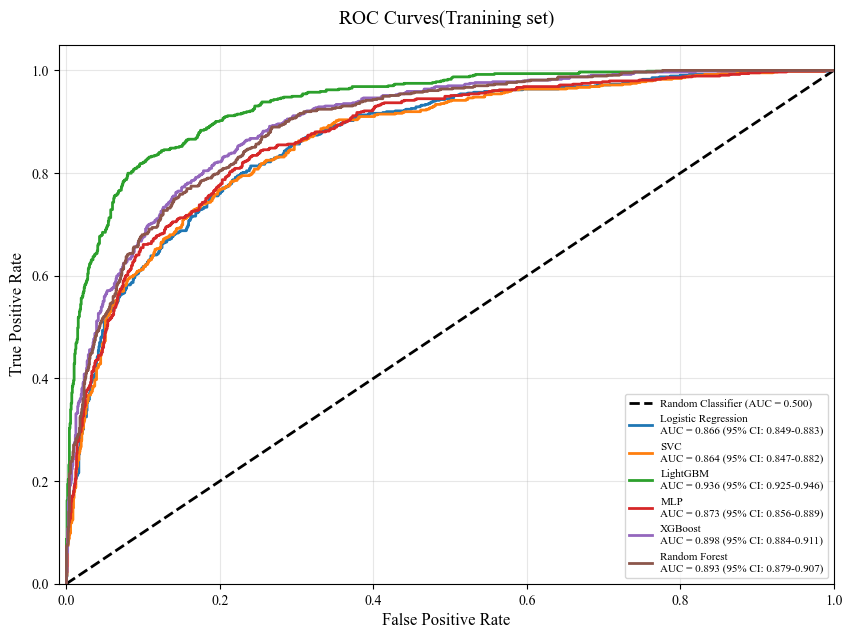

In [28]:
# ====================== 定义Bootstrap AUC函数 ======================
def bootstrap_auc(y_true, y_proba, n_bootstraps=1000):
    bootstrapped_auc = []
    n_samples = len(y_true)
    
    for _ in range(n_bootstraps):
        indices = resample(np.arange(n_samples), replace=True)
        y_true_boot = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
        y_proba_boot = y_proba[indices]
        
        if len(np.unique(y_true_boot)) >= 2:
            fpr, tpr, _ = roc_curve(y_true_boot, y_proba_boot)
            bootstrapped_auc.append(auc(fpr, tpr))
    
    lower = np.percentile(bootstrapped_auc, 2.5)
    upper = np.percentile(bootstrapped_auc, 97.5)
    return lower, upper

# ====================== 绘图代码 ======================
plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.500)')

models = {
    "Logistic Regression": LOfinal_model,
    "SVC": SVCfinal_model,
    "LightGBM": GBMfinal_model,
    "MLP": MLPfinal_model,
    "XGBoost": XGBfinal_model,
    "Random Forest": RFfinal_model
}

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(x_train)[:, 1]
        fpr, tpr, _ = roc_curve(y_train, y_proba)
        roc_auc = auc(fpr, tpr)
        lower, upper = bootstrap_auc(y_train, y_proba, n_bootstraps=1000)
        label = f"{name}\nAUC = {roc_auc:.3f} (95% CI: {lower:.3f}-{upper:.3f})"
        plt.plot(fpr, tpr, lw=2, label=label)

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves(Tranining set)', fontsize=14, pad=15)
plt.legend(loc='lower right', fontsize=8)
plt.grid(alpha=0.3)
plt.show()

验证集

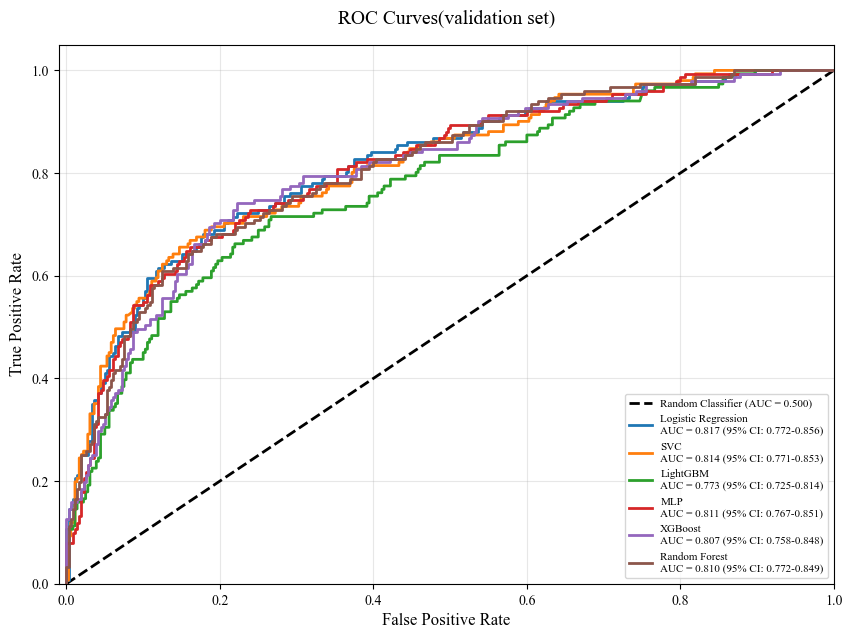

In [29]:
# ====================== 定义Bootstrap AUC函数 ======================
def bootstrap_auc(y_true, y_proba, n_bootstraps=1000):
    bootstrapped_auc = []
    n_samples = len(y_true)
    
    for _ in range(n_bootstraps):
        indices = resample(np.arange(n_samples), replace=True)
        y_true_boot = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
        y_proba_boot = y_proba[indices]
        
        if len(np.unique(y_true_boot)) >= 2:
            fpr, tpr, _ = roc_curve(y_true_boot, y_proba_boot)
            bootstrapped_auc.append(auc(fpr, tpr))
    
    lower = np.percentile(bootstrapped_auc, 2.5)
    upper = np.percentile(bootstrapped_auc, 97.5)
    return lower, upper

# ====================== 绘图代码 ======================
plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.500)')

models = {
    "Logistic Regression": LOfinal_model,
    "SVC": SVCfinal_model,
    "LightGBM": GBMfinal_model,
    "MLP": MLPfinal_model,
    "XGBoost": XGBfinal_model,
    "Random Forest": RFfinal_model
}

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(x_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        roc_auc = auc(fpr, tpr)
        lower, upper = bootstrap_auc(y_val, y_proba, n_bootstraps=1000)
        label = f"{name}\nAUC = {roc_auc:.3f} (95% CI: {lower:.3f}-{upper:.3f})"
        plt.plot(fpr, tpr, lw=2, label=label)

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves(validation set)', fontsize=14, pad=15)
plt.legend(loc='lower right', fontsize=8)
plt.grid(alpha=0.3)
plt.show()

测试集

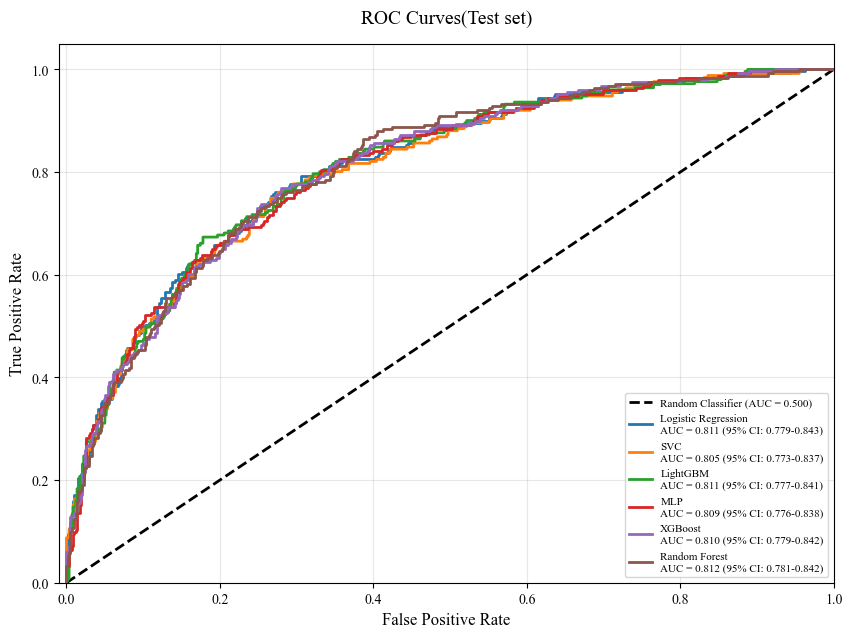

In [30]:
# ====================== 定义Bootstrap AUC函数 ======================
def bootstrap_auc(y_true, y_proba, n_bootstraps=1000):
    bootstrapped_auc = []
    n_samples = len(y_true)
    
    for _ in range(n_bootstraps):
        indices = resample(np.arange(n_samples), replace=True)
        y_true_boot = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
        y_proba_boot = y_proba[indices]
        
        if len(np.unique(y_true_boot)) >= 2:
            fpr, tpr, _ = roc_curve(y_true_boot, y_proba_boot)
            bootstrapped_auc.append(auc(fpr, tpr))
    
    lower = np.percentile(bootstrapped_auc, 2.5)
    upper = np.percentile(bootstrapped_auc, 97.5)
    return lower, upper

# ====================== 绘图代码 ======================
plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.500)')

models = {
    "Logistic Regression": LOfinal_model,
    "SVC": SVCfinal_model,
    "LightGBM": GBMfinal_model,
    "MLP": MLPfinal_model,
    "XGBoost": XGBfinal_model,
    "Random Forest": RFfinal_model
}

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(x_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        lower, upper = bootstrap_auc(y_test, y_proba, n_bootstraps=1000)
        label = f"{name}\nAUC = {roc_auc:.3f} (95% CI: {lower:.3f}-{upper:.3f})"
        plt.plot(fpr, tpr, lw=2, label=label)

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves(Test set)', fontsize=14, pad=15)
plt.legend(loc='lower right', fontsize=8)
plt.grid(alpha=0.3)
plt.show()

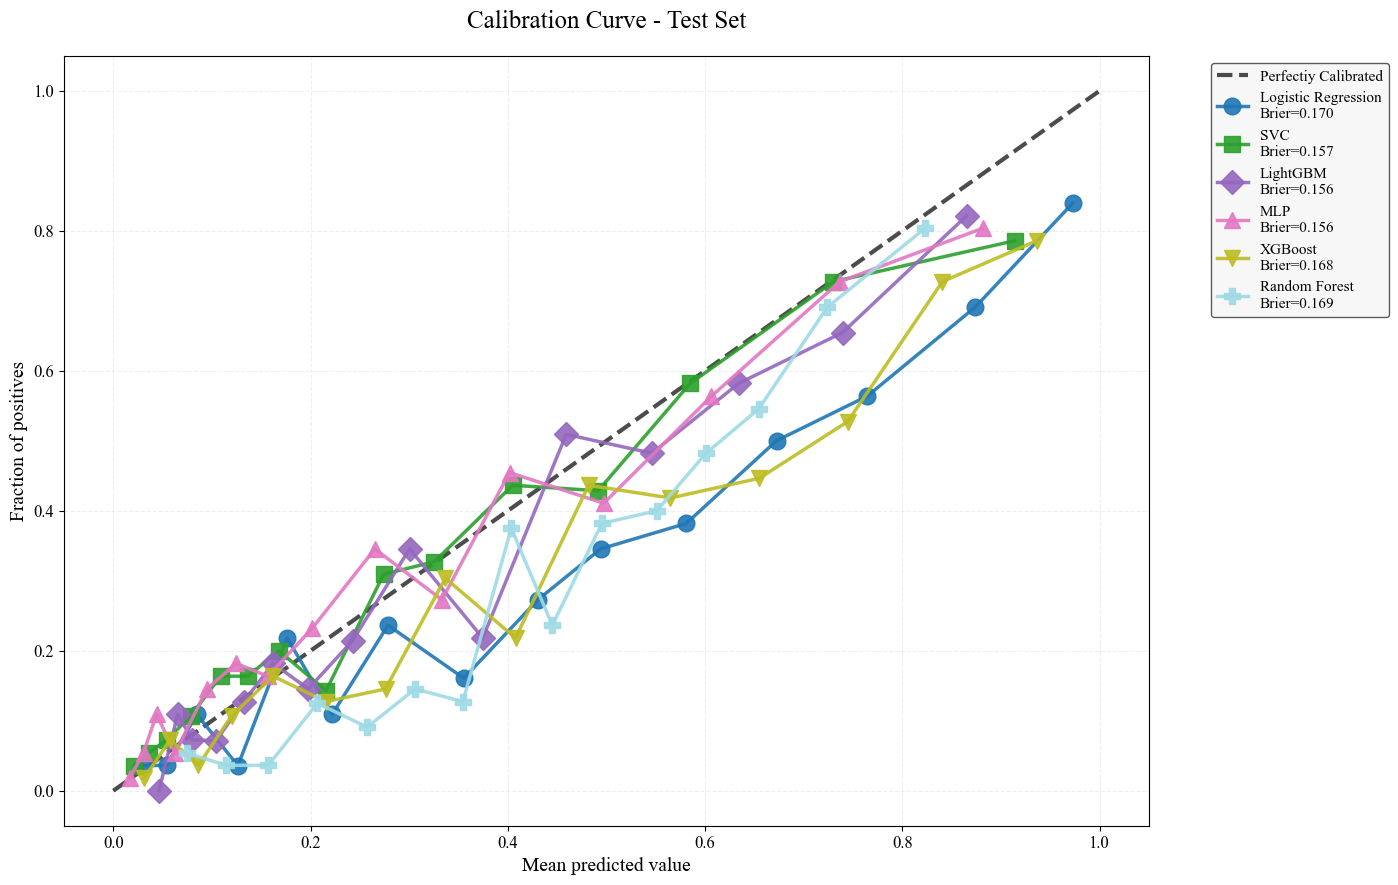

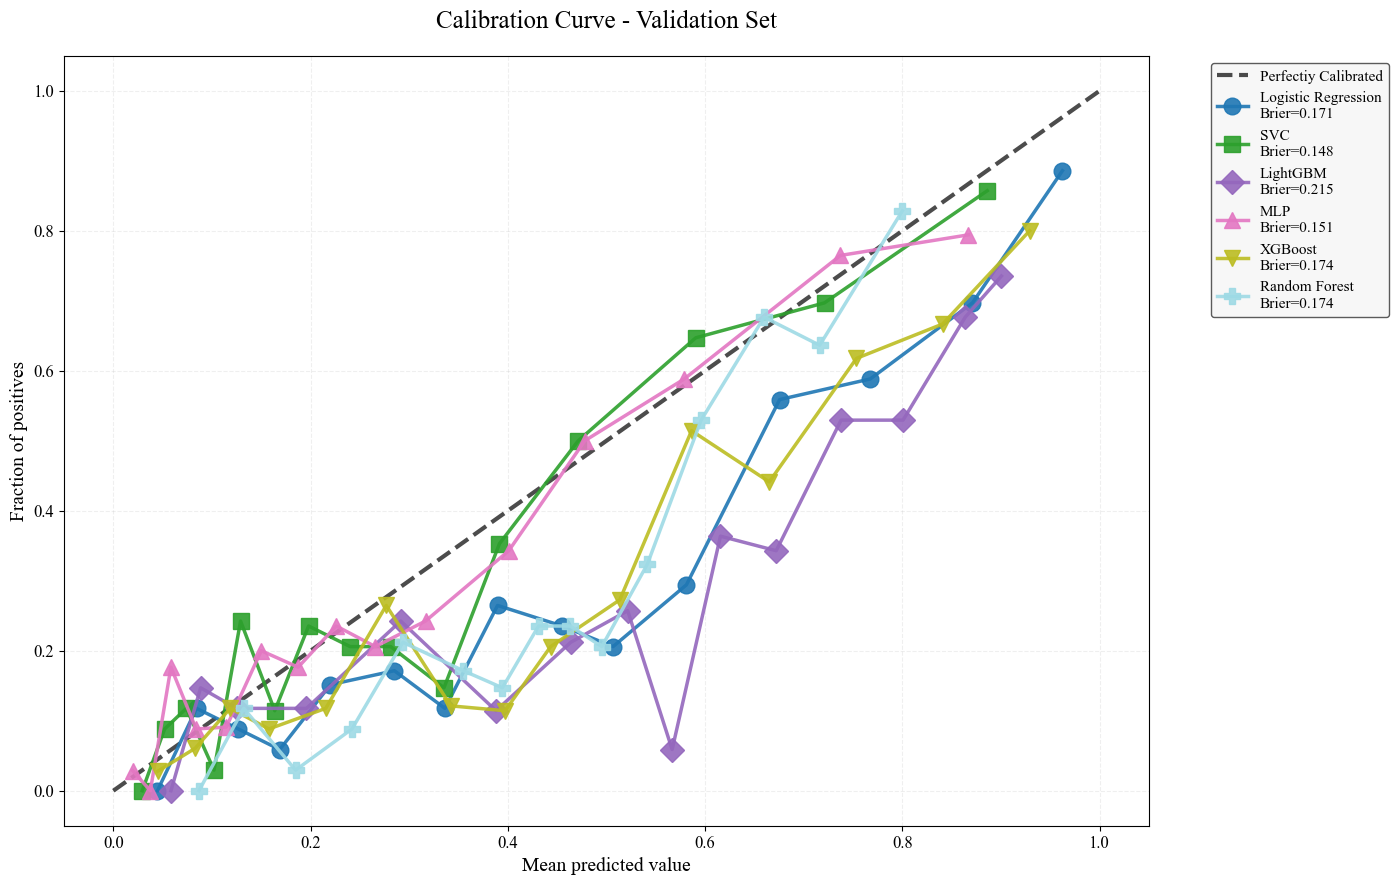

In [31]:
# ====================== 定义模型字典 ======================
models = {
    "Logistic Regression": LOfinal_model,
    "SVC": SVCfinal_model,
    "LightGBM": GBMfinal_model,
    "MLP": MLPfinal_model,
    "XGBoost": XGBfinal_model,
    "Random Forest": RFfinal_model
}

# ====================== 校准曲线函数 ======================
def plot_calibration_curves(models_dict, X, y, dataset_name="", figsize=(14, 10)):
    plt.figure(figsize=figsize)
    plt.plot([0, 1], [0, 1], "k--", linewidth=3, label="Perfectiy Calibrated", alpha=0.7)
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(models_dict)))
    markers = ['o', 's', 'D', '^', 'v', 'P']
    
    for idx, (model_name, model) in enumerate(models_dict.items()):
        try:
            y_proba = model.predict_proba(X)[:, 1]  # 获取正类概率
        except AttributeError:
            print(f"{model_name} 不支持概率预测，已跳过")
            continue
        
        # 计算校准曲线
        prob_true, prob_pred = calibration_curve(
            y, y_proba, n_bins=15, strategy='quantile'
        )
        
        # 计算Brier分数
        brier = brier_score_loss(y, y_proba)
        
        # 绘制曲线
        plt.plot(prob_pred, prob_true, 
                marker=markers[idx % len(markers)],
                markersize=12,
                linestyle='-',
                linewidth=2.5,
                color=colors[idx],
                alpha=0.9,
                label=f"{model_name}\nBrier={brier:.3f}")
    
    # 图表美化
    plt.title(f"Calibration Curve - {dataset_name}", fontsize=18, pad=20)
    plt.xlabel("Mean predicted value", fontsize=14)
    plt.ylabel("Fraction of positives", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, alpha=0.2, linestyle='--')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    
    leg = plt.legend(loc='upper left', 
                   bbox_to_anchor=(1.05, 1),
                   borderaxespad=0.5,
                   frameon=True,
                   edgecolor='#333333',
                   fontsize=11,
                   title_fontsize=12)
    leg.get_frame().set_facecolor('#F5F5F5')

# 测试集校准分析
plot_calibration_curves(
    models_dict=models,  
    X=x_test,
    y=y_test,
    dataset_name="Test Set"
)

# 验证集校准分析
plot_calibration_curves(
    models_dict=models,
    X=x_val,
    y=y_val,
    dataset_name="Validation Set"
)

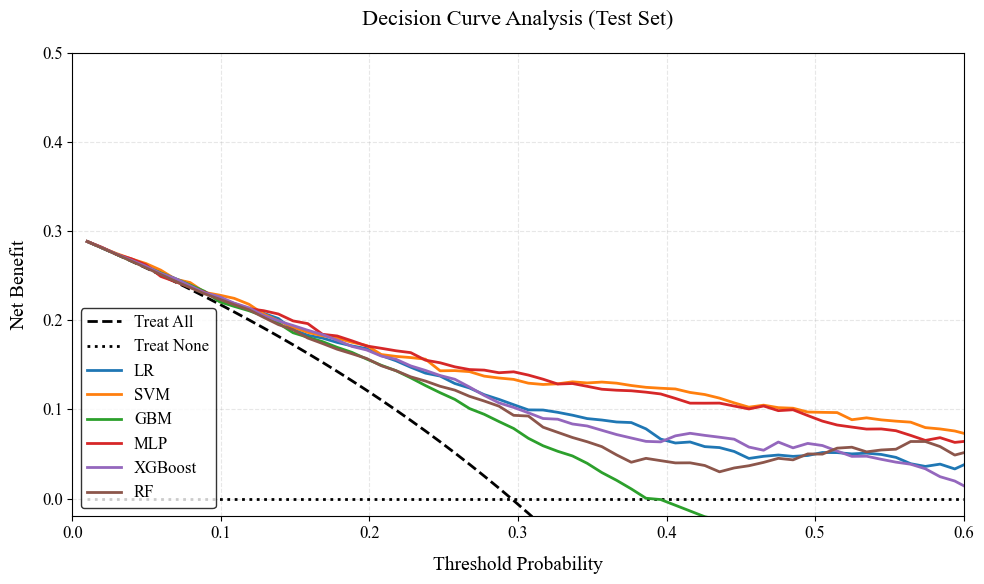

In [32]:
def calculate_net_benefit(y_true, y_prob, thresholds):
    net_benefits = []
    n = len(y_true)
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        net_benefit = (tp / n) - (fp / n) * (threshold / (1 - threshold))
        net_benefits.append(net_benefit)
    
    return np.array(net_benefits)

def plot_dca_validation(models, x_val, y_val):
    thresholds = np.linspace(0.01, 0.99, 100)
    
    plt.figure(figsize=(10, 6), dpi=100)
    plt.rc('font', size=12)

    # 基准线计算
    plt.plot(thresholds, 
             calculate_net_benefit(y_val, np.ones_like(y_val), thresholds),
             'k--', linewidth=2, label='Treat All')
    plt.plot(thresholds, 
             [0]*len(thresholds),  # Treat None的净收益始终为0
             'k:', linewidth=2, label='Treat None')

    # 自定义颜色方案
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 
              '#d62728', '#9467bd', '#8c564b']
    
    # 按示例图顺序绘制模型
    for (name, model), color in zip(models.items(), colors):
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(x_val)[:, 1]
            
            label_map = {
                "Logistic Regression": "LR",
                "SVC": "SVM",
                "LightGBM":"GBM",
                "MLP":"MLP",
                "XGBoost": "XGBoost",
               "Random Forest": "RF", 
            }
            plt.plot(thresholds, 
                     calculate_net_benefit(y_val, y_prob, thresholds),
                     color=color,
                     linewidth=2,
                     label=label_map.get(name, name))

    # 坐标轴设置
    plt.xlim(0, 0.6)
    plt.ylim(-0.02, 0.5)  # 与示例图范围一致
    plt.xlabel("Threshold Probability", fontsize=14, labelpad=10)
    plt.ylabel("Net Benefit", fontsize=14, labelpad=10)
    plt.title("Decision Curve Analysis (Test Set)", fontsize=16, pad=20)

    # 网格线和图例
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(loc='lower left', frameon=True, 
              edgecolor='black', fontsize=12)

    plt.tight_layout()
    plt.show()

models = {
    "Logistic Regression": LOfinal_model, 
    "SVC": SVCfinal_model,
    "LightGBM": GBMfinal_model,
    "MLP": MLPfinal_model,
    "XGBoost": XGBfinal_model,
    "Random Forest": RFfinal_model
}

# 使用验证集数据
plot_dca_validation(models, x_val, y_val)

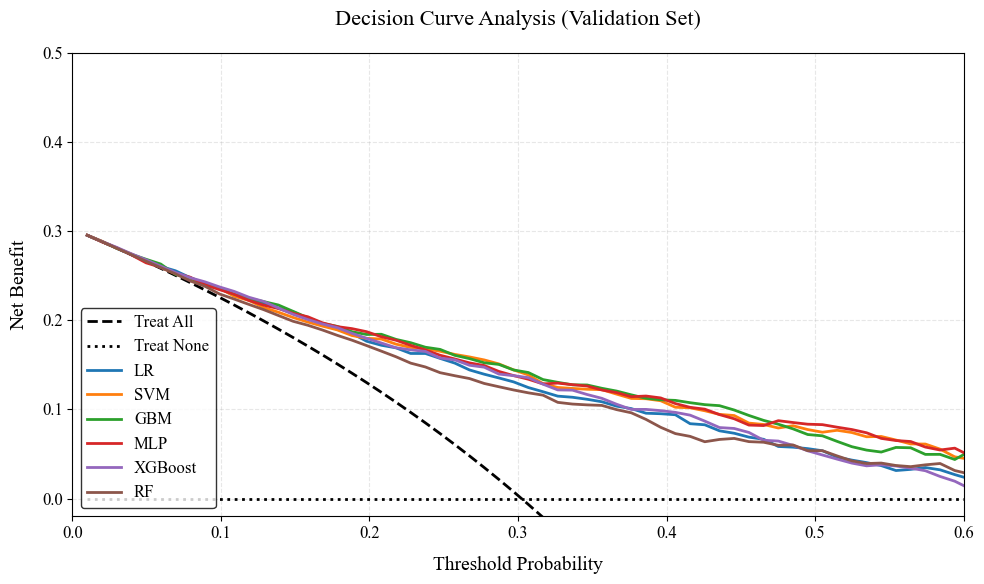

In [33]:
def calculate_net_benefit(y_true, y_prob, thresholds):
    net_benefits = []
    n = len(y_true)
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        net_benefit = (tp / n) - (fp / n) * (threshold / (1 - threshold))
        net_benefits.append(net_benefit)
    
    return np.array(net_benefits)

def plot_dca_validation(models, x_test, y_test):
    thresholds = np.linspace(0.01, 0.99, 100)
    plt.figure(figsize=(10, 6), dpi=100)
    plt.rc('font', size=12)

    # 基准线计算
    plt.plot(thresholds, 
             calculate_net_benefit(y_test, np.ones_like(y_test), thresholds),
             'k--', linewidth=2, label='Treat All')
    plt.plot(thresholds, 
             [0]*len(thresholds),  # Treat None的净收益始终为0
             'k:', linewidth=2, label='Treat None')

    # 自定义颜色方案
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 
              '#d62728', '#9467bd', '#8c564b']
    
    # 按示例图顺序绘制模型（调整模型名称对应关系）
    for (name, model), color in zip(models.items(), colors):
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(x_test)[:, 1]
            label_map = {
                "Logistic Regression": "LR",
                "SVC": "SVM",
                "LightGBM":"GBM",
                "MLP":"MLP",
                "XGBoost": "XGBoost",
               "Random Forest": "RF", 
            }
            plt.plot(thresholds, 
                     calculate_net_benefit(y_test, y_prob, thresholds),
                     color=color,
                     linewidth=2,
                     label=label_map.get(name, name))

    # 坐标轴设置
    plt.xlim(0, 0.6)
    plt.ylim(-0.02, 0.5)  # 与示例图范围一致
    plt.xlabel("Threshold Probability", fontsize=14, labelpad=10)
    plt.ylabel("Net Benefit", fontsize=14, labelpad=10)
    plt.title("Decision Curve Analysis (Validation Set)", fontsize=16, pad=20)

    # 网格线和图例
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(loc='lower left', frameon=True, 
              edgecolor='black', fontsize=12)

    plt.tight_layout()
    plt.show()

models = {
    "Logistic Regression": LOfinal_model, 
    "SVC": SVCfinal_model,
    "LightGBM": GBMfinal_model,
    "MLP": MLPfinal_model,
    "XGBoost": XGBfinal_model,
    "Random Forest": RFfinal_model
}

# 使用验证集数据
plot_dca_validation(models, x_test, y_test)

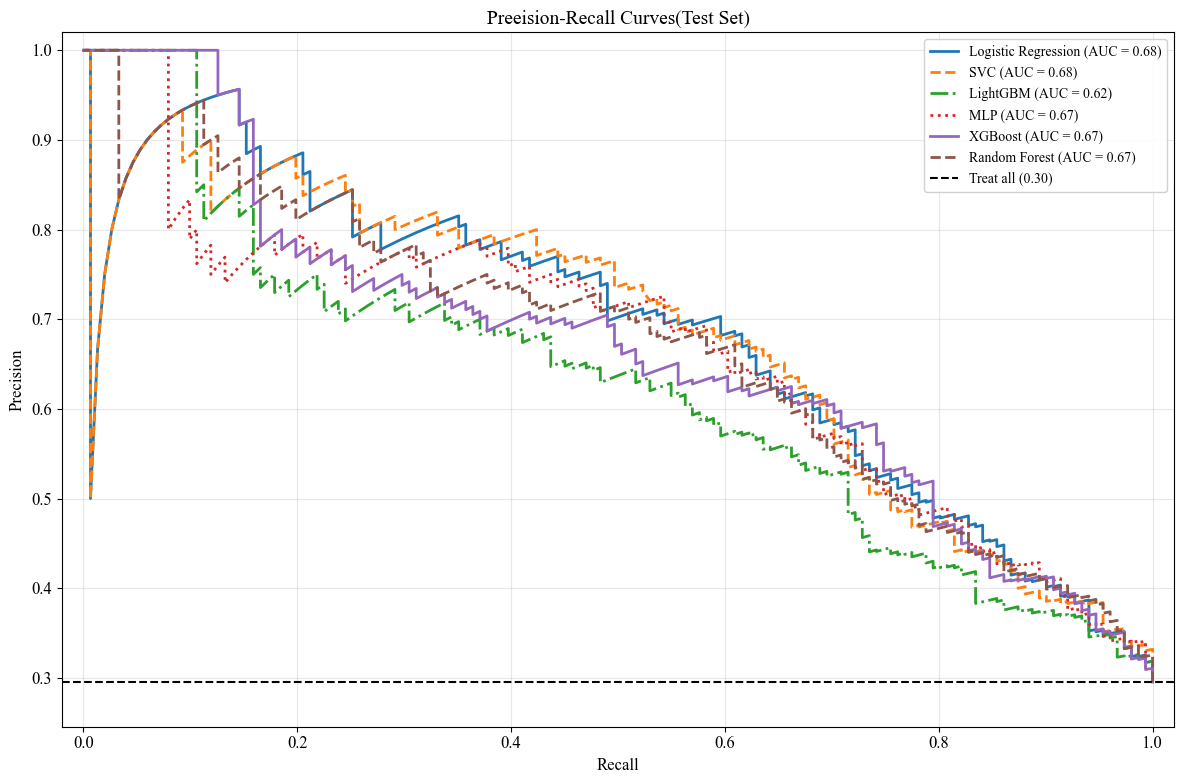

In [34]:
colors = plt.cm.tab10.colors
line_styles = ['-', '--', '-.', ':']

models = {
    "Logistic Regression": LOfinal_model, 
    "SVC": SVCfinal_model,
    "LightGBM": GBMfinal_model,
    "MLP": MLPfinal_model,
    "XGBoost": XGBfinal_model,
    "Random Forest": RFfinal_model
}

plt.figure(figsize=(12, 8))
baseline = np.mean(y_val)  # 正类比例

# 遍历所有模型
for idx, (model_name, model) in enumerate(models.items()):
    try:
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(x_val)[:, 1]
        elif hasattr(model, "decision_function"):
            y_proba = model.decision_function(x_val)
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
        
        # 计算PR曲线
        precision, recall, _ = precision_recall_curve(y_val, y_proba)
        pr_auc = auc(recall, precision)
        
        # 绘制曲线
        plt.plot(recall, precision,
                 color=colors[idx % len(colors)],
                 linestyle=line_styles[idx % len(line_styles)],
                 lw=2,
                 label=f'{model_name} (AUC = {pr_auc:.2f})')
    except Exception as e:
        print(f"{model_name} 绘制失败: {str(e)}")

# 绘制参考线
plt.axhline(y=baseline, color='k', linestyle='--', label=f'Treat all ({baseline:.2f})')

# 图表美化
plt.xlim([-0.02, 1.02])
plt.ylim([max(0, baseline-0.05), 1.02])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Preeision-Recall Curves(Test Set)', fontsize=14)
plt.legend(loc='upper right' if baseline < 0.5 else 'lower left', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

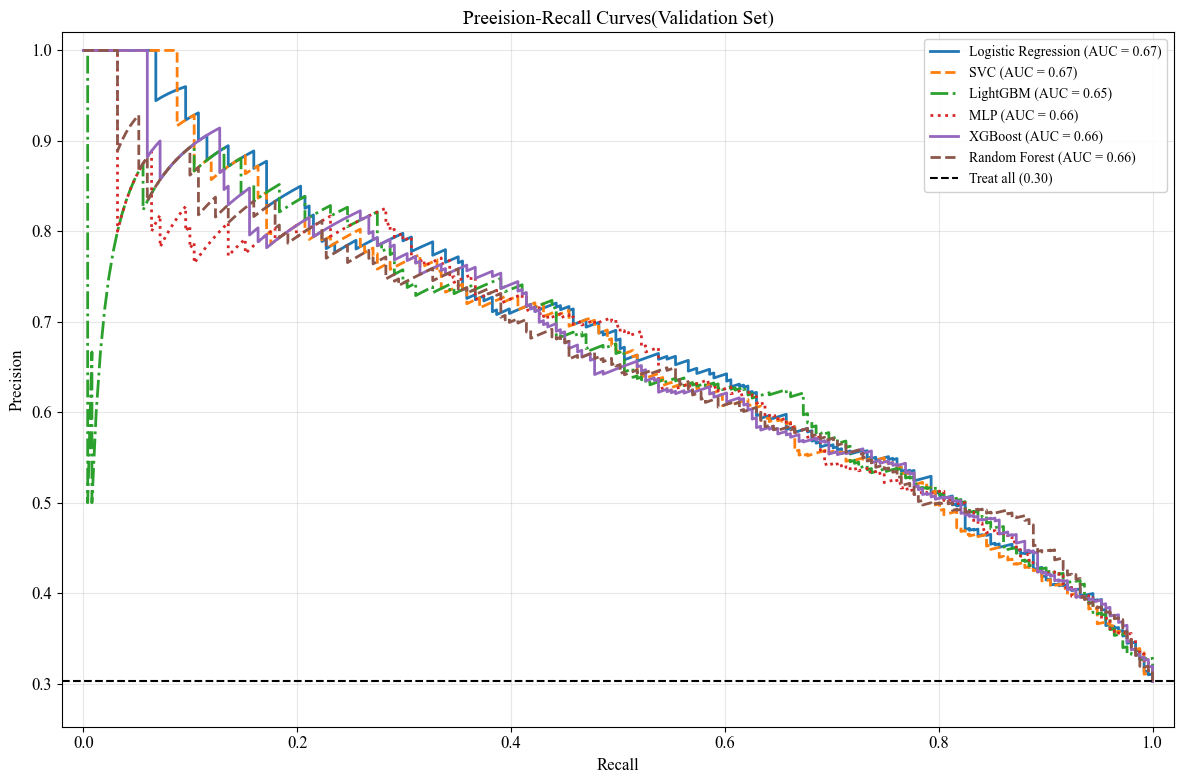

In [35]:

colors = plt.cm.tab10.colors
line_styles = ['-', '--', '-.', ':']

models = {
    "Logistic Regression": LOfinal_model, 
    "SVC": SVCfinal_model,
    "LightGBM": GBMfinal_model,
    "MLP": MLPfinal_model,
    "XGBoost": XGBfinal_model,
    "Random Forest": RFfinal_model
}

plt.figure(figsize=(12, 8))
baseline = np.mean(y_test)  # 正类比例

# 遍历所有模型
for idx, (model_name, model) in enumerate(models.items()):
    try:
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(x_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_proba = model.decision_function(x_test)
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
        
        # 计算PR曲线
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = auc(recall, precision)
        
        # 绘制曲线
        plt.plot(recall, precision,
                 color=colors[idx % len(colors)],
                 linestyle=line_styles[idx % len(line_styles)],
                 lw=2,
                 label=f'{model_name} (AUC = {pr_auc:.2f})')
    except Exception as e:
        print(f"{model_name} 绘制失败: {str(e)}")

# 绘制参考线
plt.axhline(y=baseline, color='k', linestyle='--', label=f'Treat all ({baseline:.2f})')

# 图表美化
plt.xlim([-0.02, 1.02])
plt.ylim([max(0, baseline-0.05), 1.02])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Preeision-Recall Curves(Validation Set)', fontsize=14)
plt.legend(loc='upper right' if baseline < 0.5 else 'lower left', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

SHAP

In [36]:
import shap
from sklearn.ensemble import RandomForestClassifier  # 或RandomForestRegressor
from sklearn.pipeline import Pipeline

In [37]:
df=pd.read_csv("D:/shuju/yiyu/2018nian.csv")
data=df[['gender','srh','adlab_c','arthre','digeste','retire','satlife','sleep','disability','shangwang'
        ,'hope','fall_down','eyesight_close','hear','edu','pension','tengtong','yiyu']]
x = data[['gender','srh','adlab_c','arthre','digeste','retire','satlife','sleep','disability','shangwang'
        ,'hope','fall_down','eyesight_close','hear','edu','pension','tengtong']]
y = data['yiyu']
# 分割数据集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=45)

In [38]:
# 提取训练好的随机森林模型
XGB_model = xgb.XGBClassifier(learning_rate=0.1,max_depth=5,n_estimators=100,subsample=0.5)
XGB_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

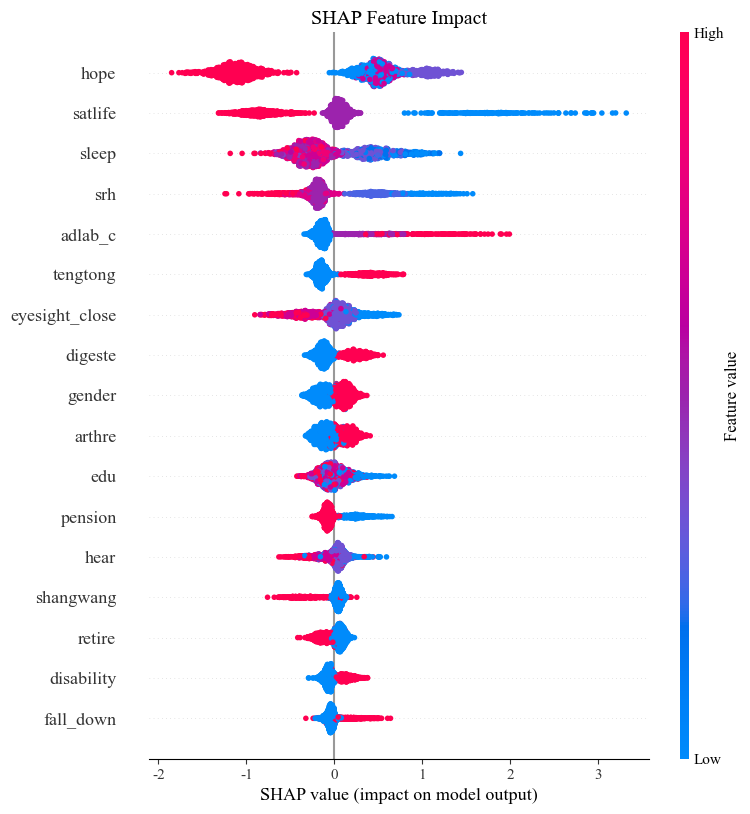

In [39]:
import numpy as np
import shap

# 确保输入数据是 NumPy 数组
x_train_np = x_train.values if hasattr(x_train, 'values') else np.array(x_train)

# 创建解释器（新版 API）
explainer = shap.Explainer(XGB_model)
shap_values = explainer(x_train_np)

# 可视化
shap.summary_plot(
    shap_values,
    x_train_np,
    feature_names=x_train.columns if hasattr(x_train, 'columns') else None,
    plot_type='dot',
    show=False
)
plt.title("SHAP Feature Impact")
plt.tight_layout()
plt.show()

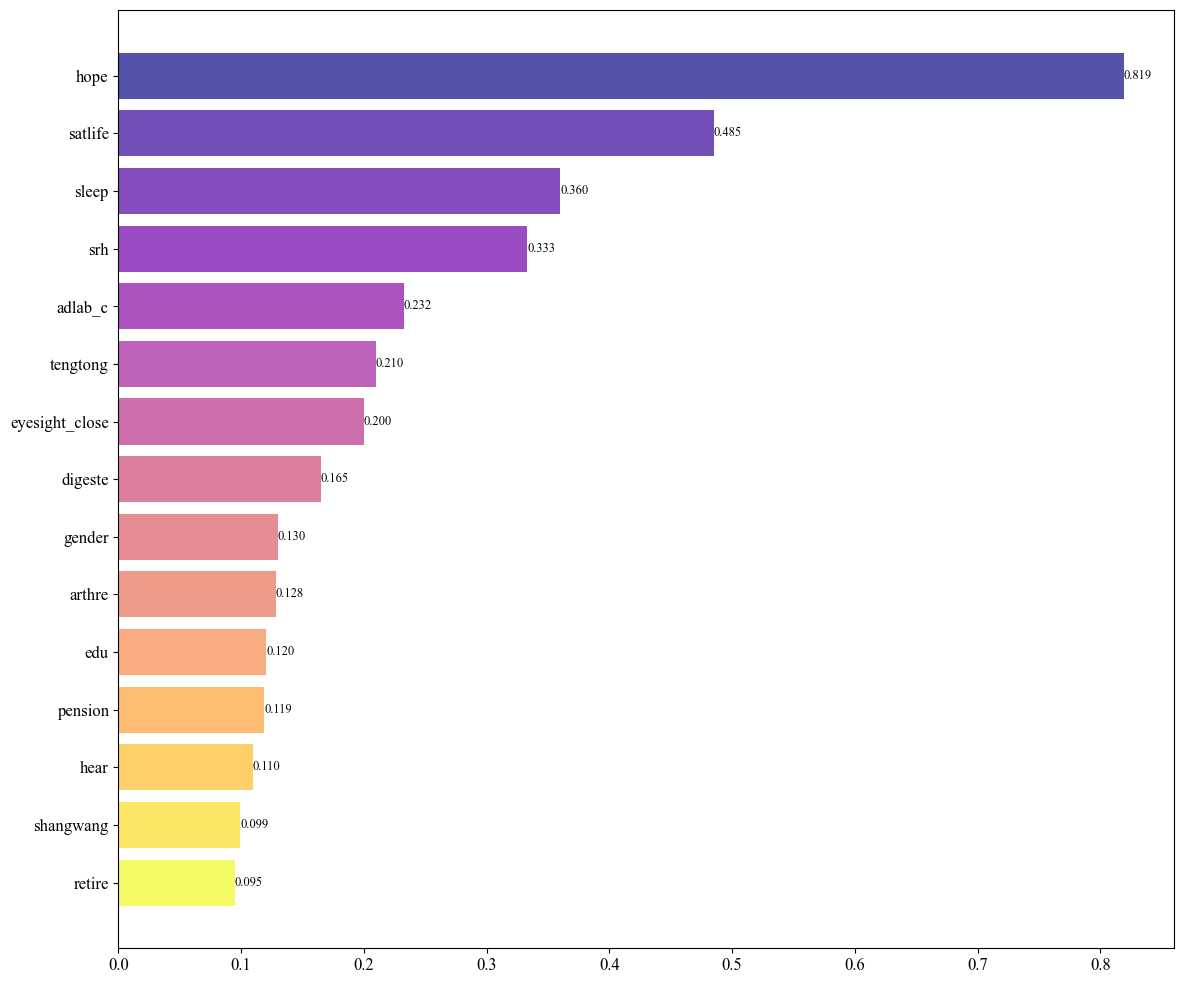

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import shap
from xgboost import XGBClassifier

# 1. 数据准备和模型训练（示例）
# x_train, y_train, x_test = ... (你的数据)
# XGB_model = XGBClassifier().fit(x_train, y_train)

# 2. 计算SHAP值
explainer = shap.Explainer(XGB_model)
shap_values = explainer(x_train)  # 获取所有样本的SHAP值

# 3. 处理SHAP值（适配分类/回归问题）
if len(shap_values.shape) == 3:  # 分类模型（n_samples, n_features, n_classes）
    shap_values_pos = shap_values[:, :, 1]  # 取正类的SHAP值
else:  # 回归模型（n_samples, n_features）
    shap_values_pos = shap_values.values if hasattr(shap_values, 'values') else shap_values

# 4. 获取正确的特征名称
def get_true_feature_names(model, x_train):
    """获取模型实际使用的特征名称"""
    try:
        # sklearn-style模型
        if hasattr(model, 'feature_names_in_'):
            return model.feature_names_in_
        # XGBoost原生模型
        elif hasattr(model, 'get_booster'):
            return model.get_booster().feature_names
    except:
        pass
    # 后备方案：使用训练数据的列名（可能不准确）
    return x_train.columns.tolist() if hasattr(x_train, 'columns') else [f"Feature_{i}" for i in range(x_train.shape[1])]

true_feature_names = get_true_feature_names(XGB_model, x_train)

# 5. 验证维度一致性
assert shap_values_pos.shape[1] == len(true_feature_names), \
    f"特征数量不匹配！SHAP值矩阵有{shap_values_pos.shape[1]}个特征，但模型有{len(true_feature_names)}个特征"

# 6. 绘图函数（增强版）
def plot_shap_bar(shap_values, feature_names, figsize=(12,10), 
                 color=None, orientation='horizontal', 
                 max_display=15):
    # 计算平均绝对SHAP值
    importance = np.abs(shap_values).mean(axis=0)
    
    # 排序并截断
    idx = np.argsort(importance)[::-1][:max_display]
    sorted_importance = importance[idx]
    sorted_features = [feature_names[i] for i in idx]
    
    # 设置颜色
    if color is None:
        color = plt.cm.plasma(np.linspace(0, 1, len(idx)))
    elif isinstance(color, str):
        color = [color] * len(idx)
    
    # 创建图表
    plt.figure(figsize=figsize)
    y_pos = np.arange(len(idx))
    bars = plt.barh(y_pos, sorted_importance, color=color, alpha=0.7)
    plt.yticks(y_pos, sorted_features)
    plt.gca().invert_yaxis()
    
    # 添加数值标签
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2.,
                f'{width:.3f}',
                ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# 7. 调用绘图
plot_shap_bar(
    shap_values_pos,
    feature_names=true_feature_names,
    max_display=15
)


<Figure size 1440x480 with 0 Axes>

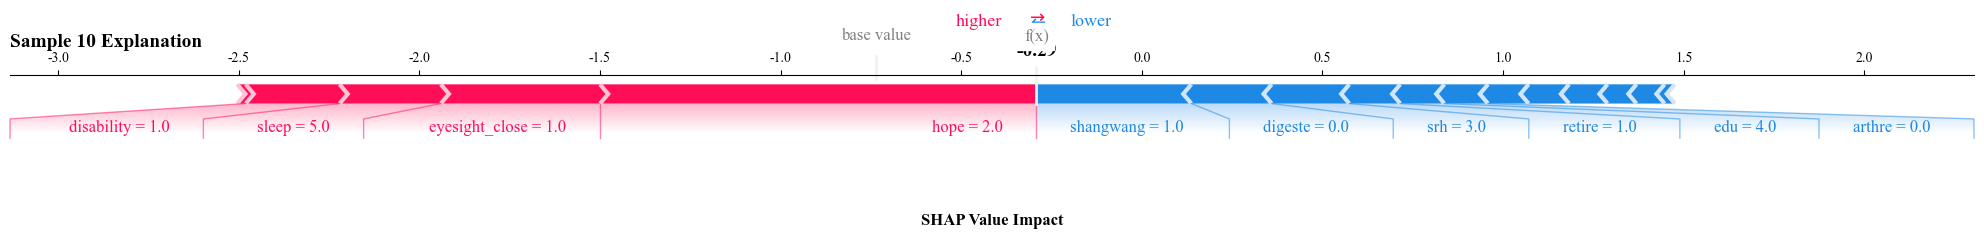

In [41]:
def plot_individual_shap(explainer, sample_data, sample_index=0, figsize=(10,5)):
    """
    生成单个样本的SHAP解释图（正确支持v0.20+版本）
    """
    # 计算SHAP值
    sample = sample_data.iloc[[sample_index]]  # 保持二维结构
    shap_values = explainer(sample)
    
    plt.figure(figsize=figsize, dpi=120)
    
    # 处理多分类情况（如果是多分类模型）
    if len(shap_values.shape) == 3:  # (样本数, 特征数, 类别数)
        class_index = 0  # 选择第一个类别进行可视化
        expected_value = explainer.expected_value[class_index]
        shap_array = shap_values.values[0, :, class_index]
    else:
        expected_value = explainer.expected_value
        shap_array = shap_values.values[0]

    # 正确的位置参数调用方式
    shap.plots.force(
        expected_value,          # 第一个位置参数：base_value
        shap_array,              # 第二个位置参数：shap_values
        features=sample.iloc[0],            # 使用单个样本的Series
        feature_names=sample_data.columns.tolist(),
        matplotlib=True,
        show=False,
        text_rotation=0,
        contribution_threshold=0.05,
        plot_cmap=['#ff0d57', '#1e88e5']
    )
    
    # 优化显示
    ax = plt.gca()
    ax.set_xlabel("SHAP Value Impact", fontsize=12, labelpad=10, fontweight='semibold')
    ax.tick_params(axis='x', labelsize=10)
    ax.set_title(f"Sample {sample_index} Explanation", 
                fontsize=14, pad=20, fontweight='bold', loc='left')
    plt.tight_layout()
    plt.show()



# 使用示例
# 假设已有预处理好的数据x和训练好的explainer
plot_individual_shap(explainer=explainer, 
                    sample_data=x_train, 
                    sample_index=10,  # 选择需要解释的样本索引
                    figsize=(12,4))

<Figure size 1440x120 with 0 Axes>

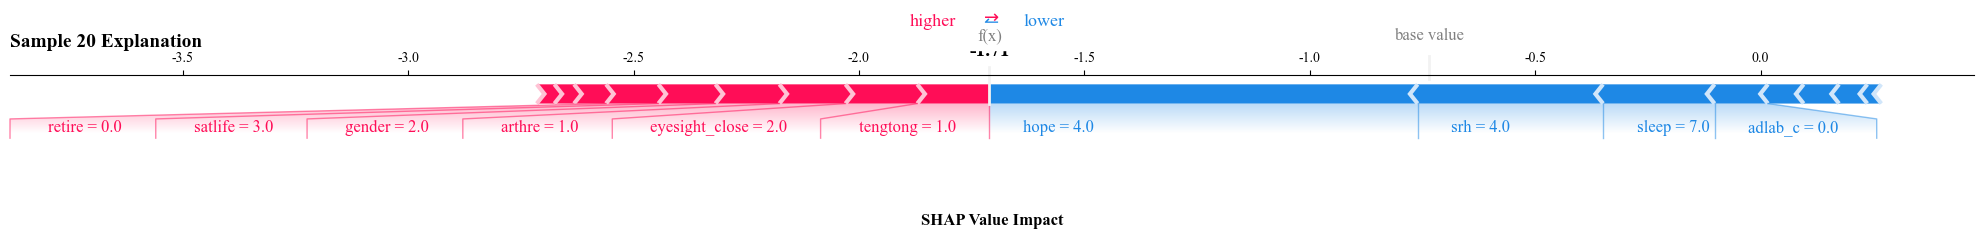

In [42]:
def plot_individual_shap(explainer, sample_data, sample_index=0, figsize=(10,5)):

    # 计算SHAP值
    sample = sample_data.iloc[[sample_index]]  # 保持二维结构
    shap_values = explainer(sample)
    
    plt.figure(figsize=figsize, dpi=120)
    
    # 处理多分类情况（如果是多分类模型）
    if len(shap_values.shape) == 3:  # (样本数, 特征数, 类别数)
        class_index = 0  # 选择第一个类别进行可视化
        expected_value = explainer.expected_value[class_index]
        shap_array = shap_values.values[0, :, class_index]
    else:
        expected_value = explainer.expected_value
        shap_array = shap_values.values[0]

    # 正确的位置参数调用方式
    shap.plots.force(
        expected_value,          # 第一个位置参数：base_value
        shap_array,              # 第二个位置参数：shap_values
        features=sample.iloc[0],            # 使用单个样本的Series
        feature_names=sample_data.columns.tolist(),
        matplotlib=True,
        show=False,
        text_rotation=0,
        contribution_threshold=0.05,
        plot_cmap=['#ff0d57', '#1e88e5']
    )
    
    # 优化显示
    ax = plt.gca()
    ax.set_xlabel("SHAP Value Impact", fontsize=12, labelpad=10, fontweight='semibold')
    ax.tick_params(axis='x', labelsize=10)
    ax.set_title(f"Sample {sample_index} Explanation", 
                fontsize=14, pad=20, fontweight='bold', loc='left')
    plt.tight_layout()
    plt.show()



# 使用示例
# 假设已有预处理好的数据x和训练好的explainer
plot_individual_shap(explainer=explainer, 
                    sample_data=x_train, 
                    sample_index=20,  # 选择需要解释的样本索引
                    figsize=(12,1))

In [43]:
import joblib
joblib.dump(XGB_model, "XGB.pkl")

['XGB.pkl']

SyntaxError: invalid syntax (1250440503.py, line 1)